# Début d'implémentation du modèle

### Étape 0 : Importations

In [1]:
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn.functional as F

import math
import pandas as pd

import time

from random import *
import random
from random import randrange
from random import sample 

from numpy.random import multinomial

### Étape 1 : Créations du corpus

In [2]:
liste_couples = {
    0:("homme","femme"),
    1:("chien","chat"),
    2:("vanille","chocolat"),
    3:("poli","courtois"),
    4:("choqué","horrifié"),
    5:("propre","sale"),
    6:("canapé","fauteuil"),
    7:("téléphone","portable"),
    8:("voiture","camion"),
    9:("grand","petit")
}

couples_contexte = {
("homme","femme") : ["sexe","genre","mari","épouse","famille","inégalités","enfant","amour","couple","différence"],                  
("chien","chat") : ["animal","domestique","maison","aboyer","miauler","labrador","poil","pattes","spa","ami"],
("vanille","chocolat") : ["parfum","goût","fraise","glace","boule","gâteau","bonbon","blanc","noir","préférence"],
("poli","courtois") : ["bonjour","merci","pardon","stp","règles","apprendre","savoir-vivre","savoir-être","formule","demander"],
("choqué","horrifié") : ["peur","terreur","phobie","clown","noir","araignée","rat","cri","oh","ah"],
("propre","sale") : ["nettoyer","vaisselle","laver","savon","produit","salissures","traces","net","éclatant","brillant"],
("canapé","fauteuil") : ["maison","salon","assis","confortable","sofa","convertible","cuir","télé","accoudoir","plaid"],
("téléphone","portable") : ["appel","allo","décrocher","sms","numéro","mobile","orange","sfr","free","bouygues"],
("voiture","camion") : ["moto","véhicule","conduire","rouler","conducteur","volant","chauffeur","permis","vitesse","passager"],
("grand","petit") : ["taille","géant","nain","s","m","l","xl","mesure","énorme","longueur"]
}

bruits = ['ALLATES','NEBULES','LONGTON','PAWESIN','SORENGO','SEXTEES','TAXIONS','ELEWIJT','EPEISME','APOTOME',
'REMORVA','HOBOKEN','MALICES','SOMZEEN','NEDDOIS','RECLIVA','GILEREZ','GAULDOS','GOINFRA','RAYERES','BOTTEES','VAGITES','PRELEES','GARDERA','ANATASE','DATASSE',
'BILLAGE','POUCAVE','REFUGES','REDIMAI','SOLANGE','EMBOISE','BACHAGA','FAMINER','ECUMONS','HARWELL','VEURDES','AZURERA','ENUQUAI','MAULAIS','MEVENIR','GAUDENT',
'MENTANA','REHERSE','ARBECEY','FAUXAMI','BALADOU','REVERDI','BEDAVES','BORAMES','PONTIFE','ALESIEZ','REFIXER','IRRUIEZ','DRESSEZ','PYROIDE','GNAQUAI','LAVETON',
'RERESTA','EPRISSE','FROLERA','RAVEURS','CITRINE','NAUNHOF','FEUTRIE','RETASEE','TIMBREE','GANTERA','HALENES','SUSIENS','DEGOUTE','BINAGES','VEAUTES','LAISSAI',
'STERANE','RECERNE','RELIQUE','FLAGGER','DELAVAS','SUADERA','PINIERS','DOMPTER','CARRARE','ROSAZIA','LIMITAS','EUCLIDE','FARCANT','BLATERE','STRICTS','REFLOTS',
'PAGELLE','BLAUZAC','BROCHER','TOPDOWN','UNIFERE','EHOUPER','ASININS','ASSAKIS','HOTELES','DENIOTE']

i = 0
for mot in bruits:
    mot_min = mot.lower()
    bruits[i] = mot_min
    i += 1
    
t_corpus = []
for i in range(10000):
    indiceCouple = randrange(0,10)
    membreCouple = randrange(0,2)
    # On a notre mot clé
    mot_cle = liste_couples[indiceCouple][membreCouple]
    # On récupère les contextes, on va en tirer 5
    liste_mot = couples_contexte[liste_couples[indiceCouple]]
    ech_contexte = sample(liste_mot,5)
    # On génère le bruit 
    ech_bruit = sample(bruits,3)
    # On crée la phrase
    phrase = []
    phrase.append(mot_cle)
    for mot in ech_contexte:
        phrase.append(mot)
    for bruit in ech_bruit:
        phrase.append(bruit)
    random.shuffle(phrase)
    t_corpus.append(phrase)

### Étape 2 : Créer le vocabulaire à partir du corpus de phrases

In [3]:
voc = []
freqs = {}
for phrase in t_corpus:
    for mot in phrase:
        if mot not in voc:
            voc.append(mot)
            freqs[mot] = 1
        else:
            freqs[mot] +=1
voc_size = len(voc)
print(voc_size)

218


### Étape 3 : Calcul des probas pour le subsampling et le negative sampling

In [4]:
total_mots = 0
for phrase in t_corpus:
    total_mots += len(phrase)

In [5]:
for key, value in freqs.items():
    freqs[key] = value / total_mots

In [6]:
# Probabilité d'être gardé dans le subsampling
p_sub = {word: min((math.sqrt(freqs[word]/0.001)+1)*(0.001/freqs[word]),1) for word in freqs}

In [7]:
p_neg_1 = {word: freqs[word]**(3/4) for word in freqs}
total_neg = 0
for word in p_neg_1:
    total_neg+=p_neg_1[word]
p_neg = {word: p_neg_1[word]/total_neg for word in p_neg_1}

In [8]:
def subSampling(phrase):
    phrase_samp = []
    for mot in phrase:
        if np.random.random() < (p_sub[mot]):
                phrase_samp.append(mot)
    return phrase_samp

t_corpus_samp = []
for phrase in t_corpus:
        # Sub-sampling : pour chaque phrase, on réalise le subsampling éventuel.
        phrase_samp = subSampling(phrase)
        if len(phrase_samp)>1:
            t_corpus_samp.append(phrase_samp)

In [9]:
mot_index = {w: index for (index, w) in enumerate(voc)}
index_mot = {index: w for (index, w) in enumerate(voc)}

### Étape 4 : Création du modèle

In [10]:
from IPython.display import clear_output
from matplotlib import pyplot as plt
import collections
%matplotlib inline

def live_plot(data, figsize=(7,5), title=''):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    plt.plot(data)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.show();

In [11]:
#Couche d'entrée
def get_input_layer(word_idx):
    x = torch.zeros(voc_size).float()
    x[word_idx] = 1.0
    return x

# Choix de dimension
embedding_dims = 10
# Initialisation
# Variable : comme Tensor mais avec les valeurs qui changent pendant le traitement
W1 = Variable(torch.randn(embedding_dims, voc_size).float(), requires_grad=True)
W2 = Variable(torch.randn(voc_size, embedding_dims).float(), requires_grad=True)
num_epochs = 50 # "époques"
learning_rate = 0.01
taille_fenetre = 5
loss_tot = []

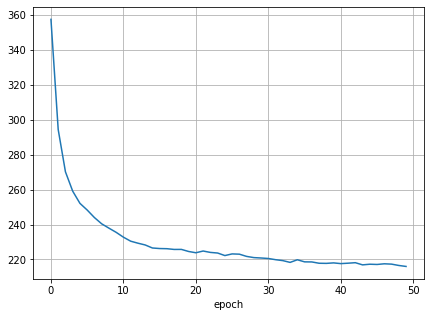

3.08


In [12]:
start = time.time()
# Différentes étapes
for epo in range(num_epochs):
    loss_val = 0
    for phrase in t_corpus_samp:
        # On crée tous les couples par phrase
        index_pairs = []
        indices = [mot_index[mot] for mot in phrase]
        # On traite chaque mot comme un mot central
        for center_word in range(len(indices)):
        # Pour chaque fenetre possible
            for w in range(-taille_fenetre, taille_fenetre + 1):
                context_word = center_word + w
                # On fait attention à ne pas sauter de phrases
                if context_word < 0 or context_word >= len(indices) or center_word == context_word:
                    continue
                context_word_ind = indices[context_word]
                index_pairs.append((indices[center_word], context_word_ind))
        if len(index_pairs) > 0:
            # On en choisit une
            focus, context = choice(index_pairs)

            # Calcul loss 

            x = Variable(get_input_layer(focus)).float()
            y = Variable(torch.from_numpy(np.array([context])).long())
            z1 = torch.matmul(W1, x)
            z2 = torch.matmul(W2, z1)
            
            # soft max
            log_softmax = F.log_softmax(z2, dim=0)
            loss = F.nll_loss(log_softmax.view(1,-1), y)
            loss_val += loss.data

            # Propagation
            loss.backward()
            W1.data -= learning_rate * W1.grad.data
            W2.data -= learning_rate * W2.grad.data

            W1.grad.data.zero_()
            W2.grad.data.zero_()
    loss_tot.append(loss_val/voc_size)
    live_plot(loss_tot)
end = time.time()
print(round((end - start)/60, 2))

In [13]:
W3 = (W1.t() + W2)/2

In [14]:
# Sauvegarder les poids - utile si traitement trop long
with open ("mat.txt", "w") as f:
    for i in range (0,len (W3)) :
        for j in range (0, len (W3[i])) :
            f.write ( str (W3[i][j]) + "\t")
        f.write ("\n")
f.close()

In [15]:
# Distance/similarité cosinus
def cos_distance(u, v):
    return (np.dot(u, v)  / (math.sqrt(np.dot(u, u)) *  (math.sqrt(np.dot(v, v)))))

In [16]:
# Dictionnaire des poids
mot_poids = {index_mot[index]: poids.detach().numpy() for (index, poids) in enumerate(W3)}

### Étape 5 : Résultats du modèle

In [17]:
def mot_plus_proche(word, n=10):
    word_distance = {}
    for mot in mot_poids:
        if mot != word:
            word_distance[mot] = (cos_distance(mot_poids[mot],(mot_poids[word])))
    word_distance = sorted(word_distance.items(), key=lambda t: t[1],reverse=True)
    return word_distance[0:n]

In [18]:
mot_plus_proche("grand")

[('l', 0.9946268748766706),
 ('m', 0.9916562449017514),
 ('mesure', 0.9904184566044802),
 ('taille', 0.9870784200686886),
 ('nain', 0.9847762100765477),
 ('s', 0.9824408915329541),
 ('xl', 0.9785003852720541),
 ('énorme', 0.9740210130525911),
 ('petit', 0.9712410781529334),
 ('géant', 0.9687156438167215)]

#### Données fictives - Construction fichier pour ACP

In [19]:
liste = ["homme","femme","chien","chat","vanille","chocolat",
    "poli","courtois","choqué","horrifié","propre","sale","canapé","fauteuil",
    "téléphone","portable","voiture","camion","grand","petit"]

df_res = pd.DataFrame.from_dict(mot_poids).transpose()
df_res = df_res.loc[liste]

In [20]:
df_res['label'] = 'Autre' 

df_res.loc["homme",'label'] = 'Couple 1'
df_res.loc["femme",'label'] = 'Couple 1'

df_res.loc["chien",'label'] = 'Couple 2'
df_res.loc["chat",'label'] = 'Couple 2'

df_res.loc["vanille",'label'] = 'Couple 3'
df_res.loc["chocolat",'label'] = 'Couple 3'

df_res.loc["poli",'label'] = 'Couple 4'
df_res.loc["courtois",'label'] = 'Couple 4'

df_res.loc["choqué",'label'] = 'Couple 5'
df_res.loc["horrifié",'label'] = 'Couple 5'

df_res.loc["propre",'label'] = 'Couple 6'
df_res.loc["sale",'label'] = 'Couple 6'

df_res.loc["canapé",'label'] = 'Couple 7'
df_res.loc["fauteuil",'label'] = 'Couple 7'

df_res.loc["téléphone",'label'] = 'Couple 8'
df_res.loc["portable",'label'] = 'Couple 8'

df_res.loc["voiture",'label'] = 'Couple 9'
df_res.loc["camion",'label'] = 'Couple 9'

df_res.loc["grand",'label'] = 'Couple 10'
df_res.loc["petit",'label'] = 'Couple 10'

In [21]:
from sklearn.preprocessing import StandardScaler
features = [0, 1, 2, 3, 4, 5, 6, 7,8 ,9]
# Separating out the features
x = df_res.loc[:, features].values
# Separating out the target
y = df_res.loc[:,['label']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

In [22]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['Axe 1', 'Axe 2'])

In [23]:
df_res['mot'] = df_res.index.values
df_res = df_res.reset_index()

In [24]:
finalDf = pd.concat([principalDf, df_res[['label','mot']]],  axis = 1)
#pca.explained_variance_ratio_

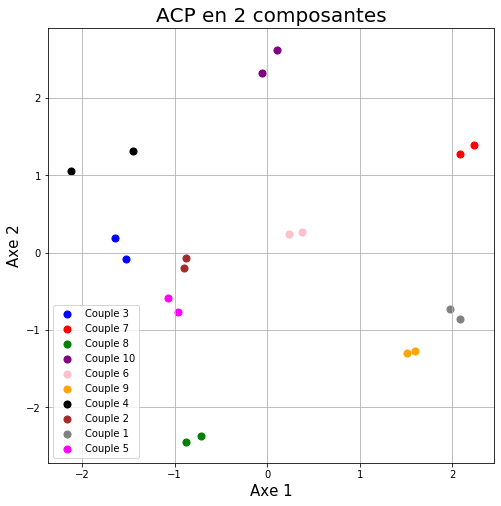

In [25]:
# Représentation simple statique 
import matplotlib
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Axe 1', fontsize = 15)
ax.set_ylabel('Axe 2', fontsize = 15)
ax.set_title('ACP en 2 composantes', fontsize = 20)
targets = list(set(df_res['label']))
colors = ['blue', 'red', 'green', 'purple', 'pink', 'orange', 'black', 'brown', 'grey', 'magenta']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['label'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'Axe 1']
               , finalDf.loc[indicesToKeep, 'Axe 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [26]:
# Représentation interactive 

import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

#Travailler avec sous-table sinon trop lourd
subFinalDf = pd.concat([finalDf[(finalDf['label'] != "Autre")],finalDf.iloc[1:100:]],  axis = 0)


subFinalDf.iplot(kind='scatter',
              mode='markers',
              x='Axe 1',
              y='Axe 2',
              categories='label',
              text='mot',
              xTitle='Axe 1',
              yTitle='Axe 2',
              title='ACP en 2 composantes',
              filename='cufflinks/simple-scatter')

### T-SNE

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd

liste2 = ["homme","femme","sexe","genre","mari","épouse","famille","inégalités","enfant","amour","couple","différence",                  
"chien","chat","animal","domestique","maison","aboyer","miauler","labrador","poil","pattes","spa","ami",
"vanille","chocolat","parfum","goût","fraise","glace","boule","gâteau","bonbon","blanc","noir","préférence",
"poli","courtois","bonjour","merci","pardon","stp","règles","apprendre","savoir-vivre","savoir-être","formule","demander",
"choqué","horrifié","peur","terreur","phobie","clown","noir","araignée","rat","cri","oh","ah",
"propre","sale","nettoyer","vaisselle","laver","savon","produit","salissures","traces","net","éclatant","brillant",
"canapé","fauteuil","maison","salon","assis","confortable","sofa","convertible","cuir","télé","accoudoir","plaid",
"téléphone","portable","appel","allo","décrocher","sms","numéro","mobile","orange","sfr","free","bouygues",
"voiture","camion","moto","véhicule","conduire","rouler","conducteur","volant","chauffeur","permis","vitesse","passager",
"grand","petit","taille","géant","nain","s","m","l","xl","mesure","énorme","longueur"
]

df_res2 = pd.DataFrame.from_dict(mot_poids).transpose()
df_res2 = df_res2.loc[liste2]

df_res2['label'] = 'Autre' 

df_res2.loc[
    ["homme","femme","sexe","genre","mari","épouse","famille","inégalités","enfant","amour","couple","différence"],
    'label'] = "Couple 1"
df_res2.loc[
    ["chien","chat","animal","domestique","maison","aboyer","miauler","labrador","poil","pattes","spa","ami"],
    'label'] = "Couple 2"
df_res2.loc[
    ["vanille","chocolat","parfum","goût","fraise","glace","boule","gâteau","bonbon","blanc","noir","préférence"],
    'label'] = "Couple 3"
df_res2.loc[
    ["poli","courtois","bonjour","merci","pardon","stp","règles","apprendre","savoir-vivre","savoir-être","formule","demander"],
    'label'] = "Couple 4"
df_res2.loc[
    ["choqué","horrifié","peur","terreur","phobie","clown","noir","araignée","rat","cri","oh","ah"],
    'label'] = "Couple 5"
df_res2.loc[
    ["propre","sale","nettoyer","vaisselle","laver","savon","produit","salissures","traces","net","éclatant","brillant"],
    'label'] = "Couple 6"
df_res2.loc[
    ["canapé","fauteuil","maison","salon","assis","confortable","sofa","convertible","cuir","télé","accoudoir","plaid"],
    'label'] = "Couple 7"
df_res2.loc[
    ["téléphone","portable","appel","allo","décrocher","sms","numéro","mobile","orange","sfr","free","bouygues"],
    'label'] = "Couple 8"
df_res2.loc[
    ["voiture","camion","moto","véhicule","conduire","rouler","conducteur","volant","chauffeur","permis","vitesse","passager"],
    'label'] = "Couple 9"
df_res2.loc[
    ["grand","petit","taille","géant","nain","s","m","l","xl","mesure","énorme","longueur"],
    'label'] = "Couple 10"

from sklearn.preprocessing import StandardScaler
features = [0, 1, 2, 3, 4, 5, 6, 7,8,9]
# Separating out the features
data_x = df_res2.loc[:, features].values
# Separating out the target
data_y = df_res2.loc[:,['label']].values

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
tsne_obj= tsne.fit_transform(data_x)

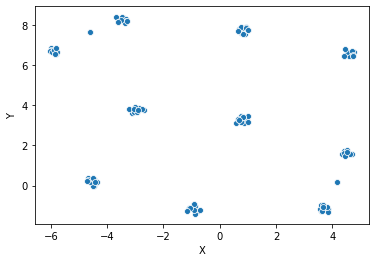

In [28]:
test_features = [1,1,1,1,1,1,1,1,1,1,1,1,
                 2,2,2,2,2,2,2,2,2,2,2,2,
                 3,3,3,3,3,3,3,3,3,3,3,3,
                 4,4,4,4,4,4,4,4,4,4,4,4,
                 5,5,5,5,5,5,5,5,5,5,5,5,
                 6,6,6,6,6,6,6,6,6,6,6,6,
                 7,7,7,7,7,7,7,7,7,7,7,7,
                 8,8,8,8,8,8,8,8,8,8,8,8,
                 9,9,9,9,9,9,9,9,9,9,9,9,
                 10,10,10,10,10,10,10,10,10,10,10,10          
                ]
tsne_df = pd.DataFrame({'X':tsne_obj[:,0],
                        'Y':tsne_obj[:,1],
                       'digit':test_features})
sns.scatterplot(x="X", y="Y",
              data=tsne_df)

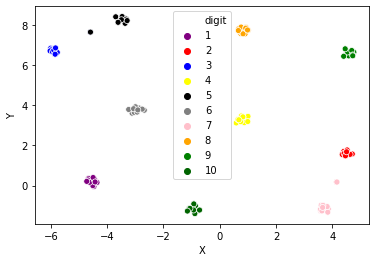

In [29]:
sns.scatterplot(x="X", y="Y",
              hue="digit",
              palette=['purple','red',"blue","yellow","black","gray","pink","orange","green","darkgreen"],
              legend='full',
              data=tsne_df);